# A simple simulation of a trapped Brownian Particle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pint
import scipy.optimize as spo

ureg = pint.UnitRegistry()
%matplotlib inline

In [2]:
t = np.linspace(0,1,100000)
x = np.empty(np.shape(t))

# First a simulation of a free particle

In [3]:
kbT = 4 * ureg.pN * ureg.nm
D = (0.27 * ureg.um**2/ureg.s)
gm = (kbT/D).to(ureg.pN/ureg.um*ureg.s)

In [4]:
dt = np.mean(np.diff(t))*ureg.s

NoiseFactor = np.sqrt((2*dt*D)).to(ureg.um).magnitude
x[0] = 0
for i,ti in enumerate(t[1:]):
    x[i+1] = x[i] + NoiseFactor*np.random.randn()

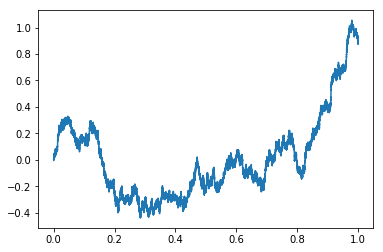

In [5]:
plt.plot(t,x)

In [6]:
trj = pd.DataFrame(data = np.array([x,t]).transpose(), index = t, columns = ["x","t"])

In [7]:
def calculate_msd(series,lag_frame,col_name=None,framerate=1,particle_id = None):
    
    if col_name is None:
        col_name = series.columns.values
        
    def msd_point(lag):
        return np.nanmean((series[col_name].values[lag:]-series[col_name].values[:-lag])**2,axis=0)
    
    columns = ["msd_"+name for name in col_name]
    
    result =  pd.DataFrame(
        data=[msd_point(lag) for lag in lag_frame],
        index=lag_frame/framerate,columns=columns)
    
    result.index.name = "dt"

    if particle_id is not None:
        result["id"] = particle_id
        result["dt"] = result.index.values
        result = result.set_index(["dt","id"])
    
    return result

In [8]:
msd = calculate_msd(trj,np.arange(1,500,1),col_name=["x"],framerate=1/dt)

C:\Users\Eric\Anaconda3\lib\site-packages\pint\quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


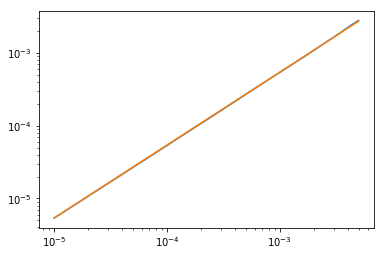

In [9]:
plt.loglog(msd)
plt.loglog(msd.index,2*msd.index*D.magnitude)

# Now a trapped particle

In [22]:
kbT = 4 * ureg.pN * ureg.nm
D = (0.0313 * ureg.um**2/ureg.s)#0.27
gm = (kbT/D).to(ureg.pN/ureg.um*ureg.s)
k = (22.88*ureg.fN/ureg.nm).to(ureg.pN/ureg.um)#20

dt = np.mean(np.diff(t))*ureg.s

NoiseFactor = np.sqrt((2*dt*D)).to(ureg.um)
ForceFactor = (dt*D/kbT).to(ureg.um/ureg.pN)

In [23]:
NoiseFactor
ForceFactor

7.825078250782508e-05 <Unit('micrometer / piconewton')>

In [24]:
dt

1.000010000100001e-05 <Unit('second')>

In [25]:
for i,ti in enumerate(t[1:]):
    ForcedTerm = ForceFactor * k*x[i]*ureg.um
    x[i+1] = x[i] + NoiseFactor.to(ureg.um).magnitude*np.random.randn() - ForcedTerm.to(ureg.um).magnitude

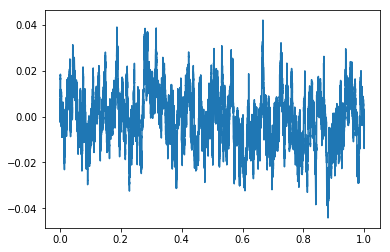

In [26]:
plt.plot(t,x)
#plt.ylim([-10,10])

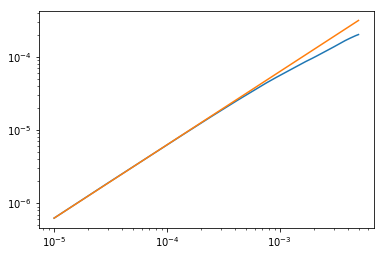

In [27]:
trj = pd.DataFrame(data = np.array([x,t]).transpose(), index = t, columns = ["x","t"])
msd = calculate_msd(trj,np.arange(1,500,1),col_name=["x"],framerate=1/dt)
plt.loglog(msd)
plt.loglog(msd.index,2*msd.index*D.magnitude)

## Force Determination in Fourier Space

In [28]:
def PSD(x,dt):
    F = np.fft.fft(x)
    N = len(x)
    PSD = (dt/N) * (F*F.conj())
    PSD = abs(PSD).astype("float64")
    f = np.linspace(0,1/dt,N) # This was changed
    return np.array_split(f,2)[0], np.array_split(PSD,2)[0]

In [29]:
def lorentzian(f,A,fc):
    return A/(fc**2+f**2)

Text(0, 0.5, 'PSD [$\\mu{}$m$^2$ s]')

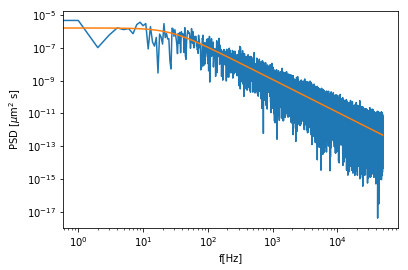

In [30]:
f, psd = PSD(trj.x,dt)

fit = spo.curve_fit(lorentzian, f, psd)

plt.loglog(f,psd)
plt.loglog(f,lorentzian(f,*fit[0]))
plt.xlabel(r"f[Hz]")
plt.ylabel(r"PSD [$\mu{}$m$^2$ s]")

In [31]:
A = fit[0][0] * ureg.um**2 / ureg.s
fc = fit[0][1] * ureg.Hz

In [32]:
gm = kbT/(2*np.pi**2*A)
display(gm.to(ureg.pN/(ureg.um/ureg.s)))
D = kbT/gm
display(D)

0.16952201398020797 <Unit('piconewton * second / micrometer')>

0.023595755536900406 <Unit('micrometer ** 2 / second')>

In [33]:
(fc*2*np.pi*gm).to(ureg.pN/ureg.nm)

0.028235771360521914 <Unit('piconewton / nanometer')>